In [14]:
!pip install python_Levenshtein-0.12.0-cp36-cp36m-win_amd64.whl

Processing c:\users\mites\documents\cognitive\textsummarization\python_levenshtein-0.12.0-cp36-cp36m-win_amd64.whl


In [1]:
import json

jsondata = []
with open('sample-1M.json') as f:
    for line in f:
        jsondata.append(json.loads(line))

In [2]:
jsondata[:1]

[{'content': 'When we are alone on a starlit night, when by chance we see the migrating birds in autumn descending on a grove of junipers to rest and eat; when we see children in a moment when they are really children, when we know love in our own hearts; or when, like the Japanese poet, Basho, we hear an old frog land in a quiet pond with a solitary splash - at such times the awakening, the turning inside out of all values, the “newness,” the emptiness and the purity of vision that make themselves evident, all these provide a glimpse of the cosmic dance.\nThomas Merton, New Seeds of Contemplation\nA famous Zen poem reads: “The old Pond. A frog jumps in. Plop”\xa0 This is a wonderful description of bare attention. The poet, Basho, goes directly to the essence of his experience: the pond, frog, plop. We can say that in meditation we are developing “plop mind”. We are stripping away everything that is extraneous to our immediate experience and simply being present with what is happening.

In [3]:
heads = [x["title"] for x in jsondata]
desc = [x["content"] for x in jsondata]

In [4]:
heads[:5]

['Getting a glimpse in a moment',
 'Treadmill workout works for injured kiwi bird',
 'Auburn-LSU Preview Capsule',
 'Dear @DirecTV – Your Randy Moss Ad is HORRIBLY Offensive',
 'Repugs, If You Think Kim Davis is Your Modern Rosa Parks, You Don’t Know Rosa Parks']

In [5]:
seed=42
vocab_size = 4000
embedding_dim = 100
lower = False # dont lower case the text

In [6]:
if lower:
    heads = [h.lower() for h in heads]

In [7]:
heads[0]

'Getting a glimpse in a moment'

In [8]:
if lower:
    desc = [h.lower() for h in desc]

In [9]:
desc[0]

'When we are alone on a starlit night, when by chance we see the migrating birds in autumn descending on a grove of junipers to rest and eat; when we see children in a moment when they are really children, when we know love in our own hearts; or when, like the Japanese poet, Basho, we hear an old frog land in a quiet pond with a solitary splash - at such times the awakening, the turning inside out of all values, the “newness,” the emptiness and the purity of vision that make themselves evident, all these provide a glimpse of the cosmic dance.\nThomas Merton, New Seeds of Contemplation\nA famous Zen poem reads: “The old Pond. A frog jumps in. Plop”\xa0 This is a wonderful description of bare attention. The poet, Basho, goes directly to the essence of his experience: the pond, frog, plop. We can say that in meditation we are developing “plop mind”. We are stripping away everything that is extraneous to our immediate experience and simply being present with what is happening. This is bare

In [10]:
len(desc),len(set(desc))

(1993, 1983)

In [11]:
len(heads),len(set(heads))

(1993, 1992)

In [12]:
from collections import Counter
from itertools import chain
def get_vocab(lst):
    vocabcount = Counter(w for txt in lst for w in txt.split())
    vocab = map(lambda x: x[0], sorted(vocabcount.items(), key=lambda x: -x[1]))
    return vocab, vocabcount

In [13]:
vocab, vocabcount = get_vocab(heads+desc)

In [14]:
vocab

In [15]:
listvocab = list(map(str,vocab))

In [16]:
print(listvocab[:5],len(listvocab))

['the', 'and', 'to', 'of', 'a'] 94228


In [17]:
listvocabcount = list(map(str,vocabcount))

In [18]:
print(listvocabcount[:5],len(listvocabcount))

['Getting', 'a', 'glimpse', 'in', 'moment'] 94228


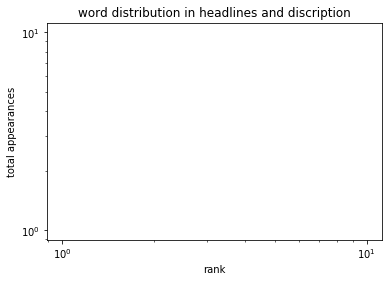

In [21]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot([vocabcount[w] for w in vocab]);
plt.gca().set_xscale("log", nonposx='clip')
plt.gca().set_yscale("log", nonposy='clip')
plt.title('word distribution in headlines and discription')
plt.xlabel('rank')
plt.ylabel('total appearances');

In [22]:
empty = 0 # RNN mask of no data
eos = 1  # end of sentence
start_idx = eos+1 # first real word

In [23]:
def get_idx(vocab, vocabcount):
    word2idx = dict((word, idx+start_idx) for idx,word in enumerate(vocab))
    word2idx['<empty>'] = empty
    word2idx['<eos>'] = eos
    
    idx2word = dict((idx,word) for word,idx in word2idx.items())

    return word2idx, idx2word

In [24]:
word2idx, idx2word = get_idx(listvocab, listvocabcount)

In [25]:
idx2word[1]

'<eos>'

In [26]:
fname = 'glove.6B.%dd.txt'%embedding_dim
import os
datadir_base = os.path.expanduser(os.path.join('~', '.keras'))
if not os.access(datadir_base, os.W_OK):
    datadir_base = os.path.join('/tmp', '.keras')
datadir = os.path.join(datadir_base, 'datasets')
glove_name = os.path.join(datadir, fname)

In [27]:
glove_name

'C:\\Users\\mites\\.keras\\datasets\\glove.6B.100d.txt'

In [28]:
glove_n_symbols = 400000

In [29]:
import numpy as np
glove_index_dict = {}
glove_embedding_weights = np.empty((glove_n_symbols, embedding_dim))
globale_scale=.1
with open(glove_name, 'r', encoding = 'utf-8') as fp:
    i = 0
    for l in fp:
        l = l.strip().split()
        w = l[0]
        glove_index_dict[w] = i
        glove_embedding_weights[i,:] = list(map(float,l[1:]))
        i += 1
glove_embedding_weights *= globale_scale

In [30]:
glove_embedding_weights.std()

0.040815727600190289

In [31]:
for w,i in glove_index_dict.items():
    w = w.lower()
    if w not in glove_index_dict:
        glove_index_dict[w] = i

In [32]:
# generate random embedding with same scale as glove
np.random.seed(seed)
shape = (vocab_size, embedding_dim)
scale = glove_embedding_weights.std()*np.sqrt(12)/2 # uniform and not normal
embedding = np.random.uniform(low=-scale, high=scale, size=shape)
print ('random-embedding/glove scale', scale, 'std', embedding.std())

# copy from glove weights of words that appear in our short vocabulary (idx2word)
c = 0
for i in range(vocab_size):
    w = idx2word[i]
    g = glove_index_dict.get(w, glove_index_dict.get(w.lower()))
    if g is None and w.startswith('#'): # glove has no hastags (I think...)
        w = w[1:]
        g = glove_index_dict.get(w, glove_index_dict.get(w.lower()))
    if g is not None:
        embedding[i,:] = glove_embedding_weights[g,:]
        c+=1
print ('number of tokens, in small vocab, found in glove and copied to embedding', c,c/float(vocab_size))

random-embedding/glove scale 0.0706949139514 std 0.0408074524671
number of tokens, in small vocab, found in glove and copied to embedding 3527 0.88175


In [33]:
glove_thr = 0.5

In [34]:
word2glove = {}
for w in word2idx:
    if w in glove_index_dict:
        g = w
    elif w.lower() in glove_index_dict:
        g = w.lower()
    elif w.startswith('#') and w[1:] in glove_index_dict:
        g = w[1:]
    elif w.startswith('#') and w[1:].lower() in glove_index_dict:
        g = w[1:].lower()
    else:
        continue
    word2glove[w] = g

In [35]:
normed_embedding = embedding/np.array([np.sqrt(np.dot(gweight,gweight)) for gweight in embedding])[:,None]

nb_unknown_words = 100

glove_match = []
for w,idx in word2idx.items():
    if idx >= vocab_size-nb_unknown_words and w.isalpha() and w in word2glove:
        gidx = glove_index_dict[word2glove[w]]
        gweight = glove_embedding_weights[gidx,:].copy()
        # find row in embedding that has the highest cos score with gweight
        gweight /= np.sqrt(np.dot(gweight,gweight))
        score = np.dot(normed_embedding[:vocab_size-nb_unknown_words], gweight)
        while True:
            embedding_idx = score.argmax()
            s = score[embedding_idx]
            if s < glove_thr:
                break
            if idx2word[embedding_idx] in word2glove :
                glove_match.append((w, embedding_idx, s)) 
                break
            score[embedding_idx] = -1
glove_match.sort(key = lambda x: -x[2])
print ('# of glove substitutes found', len(glove_match))

# of glove substitutes found 21161


In [36]:
for orig, sub, score in glove_match[-10:]:
    print (score, orig,'=>', idx2word[sub])

0.500077711179 Motherwell => Scottish
0.500076554638 breeds => wild
0.500057868754 MMS => analyst
0.500044418107 API => data
0.500044418107 api => data
0.500039092676 glee => comedy
0.500039092676 Glee => comedy
0.500033899385 Mockingjay => 3.
0.500033226634 Felix => Joseph
0.500002588865 aggressiveness => strength


In [37]:
glove_idx2idx = dict((word2idx[w],embedding_idx) for  w, embedding_idx, _ in glove_match)


In [38]:
Y = [[word2idx[token] for token in headline.split()] for headline in heads]
len(Y)

1993

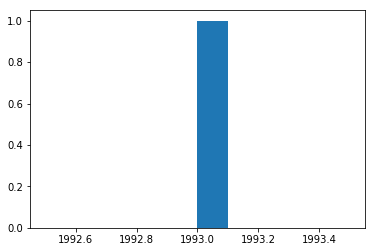

In [39]:
plt.hist(len(list(Y)),bins=10);

In [40]:
X = [[word2idx[token] for token in d.split()] for d in desc]
len(X)

1993

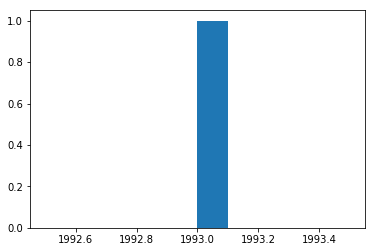

In [41]:
plt.hist(len(list(X)),bins=10);

In [42]:
import pickle
with open('data2.pkl','wb') as fp:
    pickle.dump((embedding, idx2word, word2idx, glove_idx2idx),fp,-1)

In [43]:
import pickle
with open('data3.data.pkl','wb') as fp:
    pickle.dump(X,fp,-1)

In [44]:
import keras
keras.__version__

Using TensorFlow backend.


'2.0.6'

In [110]:
maxlend=0 # 0 - if we dont want to use description at all
maxlenh=25
maxlen = maxlend + maxlenh
rnn_size = 400 # must be same as 160330-word-gen
rnn_layers = 3  # match FN1
batch_norm=False

In [46]:
activation_rnn_size = 40 if maxlend else 0

In [47]:
# training parameters
seed=4
p_W, p_U, p_dense, p_emb, weight_decay = 0, 0, 0, 0, 0
optimizer = 'adam'
LR = 1e-4
batch_size=64
nflips=10

In [48]:
nb_train_samples = 3000
nb_val_samples = 250

In [49]:
import pickle

with open('data2.pkl', 'rb') as fp:
    embedding, idx2word, word2idx, glove_idx2idx = pickle.load(fp)
vocab_size, embedding_size = embedding.shape

In [50]:
nb_unknown_words = 10

In [51]:
print ('number of examples',len(X))
print ('dimension of embedding space for words',embedding_size)
print ('vocabulary size', vocab_size, 'the last %d words can be used as place holders for unknown/oov words'%nb_unknown_words)
print ('total number of different words',len(idx2word), len(word2idx))
print ('number of words outside vocabulary which we can substitue using glove similarity', len(glove_idx2idx))
print ('number of words that will be regarded as unknonw(unk)/out-of-vocabulary(oov)',len(idx2word)-vocab_size-len(glove_idx2idx))

number of examples 1993
dimension of embedding space for words 100
vocabulary size 4000 the last 10 words can be used as place holders for unknown/oov words
total number of different words 94230 94230
number of words outside vocabulary which we can substitue using glove similarity 21161
number of words that will be regarded as unknonw(unk)/out-of-vocabulary(oov) 69069


In [52]:
for i in range(nb_unknown_words):
    idx2word[vocab_size-1-i] = '<%d>'%i

In [53]:
oov0 = vocab_size-nb_unknown_words

In [54]:
for i in range(oov0, len(idx2word)):
    idx2word[i] = idx2word[i]+'^'

In [55]:
from sklearn.cross_validation import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=nb_val_samples, random_state=seed)
len(X_train), len(Y_train), len(X_test), len(Y_test)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


(1743, 1743, 250, 250)

In [56]:
del X
del Y

In [57]:
empty = 0
eos = 1
idx2word[empty] = '_'
idx2word[eos] = '~'

In [58]:
import numpy as np
from keras.preprocessing import sequence
from keras.utils import np_utils
import random, sys

In [59]:
def prt(label, x):
    print (label+':'),
    for w in x:
        print (idx2word[w]),
    print

In [60]:
i = 3
prt('H',Y_train[i])
prt('D',X_train[i])

H:
SHAREHOLDER^
ALERT:^
Levi^
&
Korsinsky,^
LLP^
Notifies^
Shareholders^
of
Wayfair^
Inc.
of
Pendency^
of
Class^
Action^
Lawsuit^
and
a
Lead^
Plaintiff^
Deadline^
of
November
2,
2015
--
W^
D:
-
The
following
statement
is
being
issued
by
Levi^
&
Korsinsky,^
LLP:^
To:^
All
persons
or
entities^
who
purchased
or
otherwise
acquired
securities
of
Wayfair^
Inc.
(NYSE^
You
are
hereby^
notified^
that
a
class
action
has
commenced^
in
the
USDC^
for
the
Southern
District
of
New
York.^
If
you
purchased
or
otherwise
acquired
Wayfair^
securities
between
October
2,
2014
and
August
31,
2015,
your
rights
may
be
affected
by
this
action.^
To
learn
more
go
to:^
http://zlk.9nl.com/wayfair-w^
or
contact
Joseph
E.^
Levi,^
Esq.^
via
email
at
jlevi@zlk.com^
or
by
telephone
at
(877)^
363-5972.^
There
is
no
cost
or
obligation
to
you.
According
to
the
lawsuit,^
throughout
the
Class^
Period
defendants^
issued
materially
false^
and
misleading^
statements
to
investors
and/or
failed
to
disclose^
that
Overstock^
is
a
c

In [109]:
i = 3
prt('H',Y_test[i])
prt('D',X_test[i])

H:
John
Boehner
announces^
resignation^
from
Congress
D:
Updated:^
WASHINGTON^
D.C.^
--
House
Speaker^
John
Boehner
will
step
down
from
Congress
at
the
end
of
October,^
CBS
News'^
Nancy^
Cordes^
confirms.^
The
Republican
leader
has
come
under
fire
from
conservatives^
in
the
House
GOP
conference
over
whether
or
not
to
risk
shutting^
down
the
government
over
Planned^
Parenthood^
funding.^
"The
Speaker^
believes
putting
members
through
prolonged^
leadership
turmoil^
would
do
irreparable^
damage
to
the
institution,"^
an
aide^
for
Boehner
told
CBS.^
"He
is
proud
of
what
this
majority
has
accomplished,^
and
his
Speakership,^
but
for
the
good
of
the
Republican
Conference
and
the
institution,^
he
will
resign^
the
Speakership^
and
his
seat
in
Congress,^
effective
October
30."^
According
to
the
aide,^
Boehner
was
ready
to
retire^
at
the
end
of
last
year,
but
the
unexpected^
loss
of
House
Majority^
Leader
Eric^
Cantor^
--
who
was
ousted^
from
office
in
the
2016
GOP
primary
for
his
Virginia^
seat


In [62]:
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Dropout, RepeatVector
from keras.layers import Merge
from keras.layers.wrappers import TimeDistributed
from keras.layers.recurrent import LSTM
from keras.layers.embeddings import Embedding
from keras.regularizers import l2

In [63]:
# seed weight initialization
random.seed(seed)
np.random.seed(seed)

In [64]:
regularizer = l2(weight_decay) if weight_decay else None

In [111]:
model = Sequential()
model.add(Embedding(vocab_size, embedding_size,
                    input_length=maxlen,
                    W_regularizer=regularizer, dropout=p_emb, weights=[embedding], mask_zero=True,
                    name='embedding_1'))
for i in range(rnn_layers):
    lstm = LSTM(rnn_size, return_sequences=True, # batch_norm=batch_norm,
                W_regularizer=regularizer, U_regularizer=regularizer,
                b_regularizer=regularizer, dropout_W=p_W, dropout_U=p_U,
                name='lstm_%d'%(i+1)
                  )
    model.add(lstm)
    model.add(Dropout(p_dense,name='dropout_%d'%(i+1)))
    

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: The `dropout` argument is no longer support in `Embedding`. You can apply a `keras.layers.SpatialDropout1D` layer right after the `Embedding` layer to get the same behavior.
  """
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Update your `Embedding` call to the Keras 2 API: `Embedding(4000, 100, input_length=25, weights=[array([[-..., mask_zero=True, name="embedding_1", embeddings_regularizer=None)`
  """
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(400, return_sequences=True, name="lstm_1", kernel_regularizer=None, bias_regularizer=None, recurrent_regularizer=None, dropout=0, recurrent_dropout=0)`
  # Remove the CWD from sys.path while we load stuff.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(400, 

In [112]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 25, 100)           400000    
_________________________________________________________________
lstm_1 (LSTM)                (None, 25, 400)           801600    
_________________________________________________________________
dropout_1 (Dropout)          (None, 25, 400)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 25, 400)           1281600   
_________________________________________________________________
dropout_2 (Dropout)          (None, 25, 400)           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 25, 400)           1281600   
_________________________________________________________________
dropout_3 (Dropout)          (None, 25, 400)           0         
Total para

In [113]:
from keras.layers.core import Lambda
import keras.backend as K

def simple_context(X, mask, n=activation_rnn_size, maxlend=maxlend, maxlenh=maxlenh):
    desc, head = X[:,:maxlend,:], X[:,maxlend:,:]
    head_activations, head_words = head[:,:,:n], head[:,:,n:]
    desc_activations, desc_words = desc[:,:,:n], desc[:,:,n:]
    
    # RTFM http://deeplearning.net/software/theano/library/tensor/basic.html#theano.tensor.batched_tensordot
    # activation for every head word and every desc word
    activation_energies = K.batch_dot(head_activations, desc_activations, axes=(2,2))
    # make sure we dont use description words that are masked out
    activation_energies = activation_energies + -1e20*K.expand_dims(1.-K.cast(mask[:, :maxlend],'float32'),1)
    
    # for every head word compute weights for every desc word
    activation_energies = K.reshape(activation_energies,(-1,maxlend))
    activation_weights = K.softmax(activation_energies)
    activation_weights = K.reshape(activation_weights,(-1,maxlenh,maxlend))

    # for every head word compute weighted average of desc words
    desc_avg_word = K.batch_dot(activation_weights, desc_words, axes=(2,1))
    return K.concatenate((desc_avg_word, head_words))


class SimpleContext(Lambda):
    def __init__(self,**kwargs):
        super(SimpleContext, self).__init__(simple_context,**kwargs)
        self.supports_masking = True

    def compute_mask(self, input, input_mask=None):
        return input_mask[:, maxlend:]
    
    def get_output_shape_for(self, input_shape):
        nb_samples = input_shape[0]
        n = 2*(rnn_size - activation_rnn_size)
        return (nb_samples, maxlenh, n)

In [114]:
#if activation_rnn_size:
    #model.add(SimpleContext(name='simplecontext_1'))
model.add(TimeDistributed(Dense(vocab_size,
                                W_regularizer=regularizer, b_regularizer=regularizer,
                                name = 'timedistributed_1')))
model.add(Activation('softmax', name='activation_1'))

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(4000, name="timedistributed_1", kernel_regularizer=None, bias_regularizer=None)`
  """


In [115]:
from keras.optimizers import Adam, RMSprop # usually I prefer Adam but article used rmsprop
# opt = Adam(lr=LR)  # keep calm and reduce learning rate
model.compile(loss='categorical_crossentropy', optimizer=optimizer)

In [116]:
%%javascript
// new Audio("http://www.soundjay.com/button/beep-09.wav").play ()

<IPython.core.display.Javascript object>

In [117]:
K.set_value(model.optimizer.lr,np.float32(LR))

In [118]:
def str_shape(x):
    return 'x'.join(map(str,x.shape))
    
def inspect_model(model):
    for i,l in enumerate(model.layers):
        print (i, 'cls=%s name=%s'%(type(l).__name__, l.name))
        weights = l.get_weights()
        for weight in weights:
            print (str_shape(weight)),
        print


In [119]:
inspect_model(model)

0 cls=Embedding name=embedding_1
4000x100
1 cls=LSTM name=lstm_1
100x1600
400x1600
1600
2 cls=Dropout name=dropout_1
3 cls=LSTM name=lstm_2
400x1600
400x1600
1600
4 cls=Dropout name=dropout_2
5 cls=LSTM name=lstm_3
400x1600
400x1600
1600
6 cls=Dropout name=dropout_3
7 cls=TimeDistributed name=time_distributed_2
400x4000
4000
8 cls=Activation name=activation_1


In [120]:
if os.path.exists('data2.hdf5'):
    model.load_weights('data2.hdf5')

In [121]:
def lpadd(x, maxlend=maxlend, eos=eos):
    """left (pre) pad a description to maxlend and then add eos.
    The eos is the input to predicting the first word in the headline
    """
    assert maxlend >= 0
    if maxlend == 0:
        return [eos]
    n = len(x)
    if n > maxlend:
        x = x[-maxlend:]
        n = maxlend
    return [empty]*(maxlend-n) + x + [eos]

In [122]:
samples = [lpadd([3]*26)]
# pad from right (post) so the first maxlend will be description followed by headline
data = sequence.pad_sequences(samples, maxlen=maxlen, value=empty, padding='post', truncating='post')

In [123]:
np.all(data[:,maxlend] == eos)

True

In [124]:
data.shape,map(len, samples)

((1, 25), <map at 0x1fd2d6d34e0>)

In [125]:
probs = model.predict(data, verbose=0, batch_size=1)
probs.shape

(1, 25, 4000)

In [165]:
# variation to https://github.com/ryankiros/skip-thoughts/blob/master/decoding/search.py
def beamsearch(predict, start=[empty]*maxlend + [eos],
               k=1, maxsample=maxlen, use_unk=True, empty=empty, eos=eos, temperature=1.0):
    """return k samples (beams) and their NLL scores, each sample is a sequence of labels,
    all samples starts with an `empty` label and end with `eos` or truncated to length of `maxsample`.
    You need to supply `predict` which returns the label probability of each sample.
    `use_unk` allow usage of `oov` (out-of-vocabulary) label in samples
    """
    def sample(energy, n, temperature=temperature):
        """sample at most n elements according to their energy"""
        n = min(n,len(energy))
        prb = np.exp(-np.array(energy) / temperature )
        res = []
        for i in range(n):
            z = np.sum(prb)
            r = np.argmax(np.random.multinomial(1, prb/z, 1))
            res.append(r)
            prb[r] = 0. # make sure we select each element only once
        return res

    dead_k = 0 # samples that reached eos
    dead_samples = []
    dead_scores = []
    live_k = 1 # samples that did not yet reached eos
    live_samples = [list(start)]
    live_scores = [0]

    while live_k:
        # for every possible live sample calc prob for every possible label 
        probs = predict(live_samples, empty=empty)

        # total score for every sample is sum of -log of word prb
        cand_scores = np.array(live_scores)[:,None] - np.log(probs)
        len(cand_scores)
        #cand_scores[:,empty] = 1e20
        #cand_scores = cand_scores+1
        cand_scores[0] = 1e20
        if not use_unk:
            for i in range(nb_unknown_words):
                cand_scores[:,vocab_size - 1 - i] = 1e20
        live_scores = list(cand_scores.flatten())
        

        # find the best (lowest) scores we have from all possible dead samples and
        # all live samples and all possible new words added
        scores = dead_scores + live_scores
        ranks = sample(scores, k)
        n = len(dead_scores)
        ranks_dead = [r for r in ranks if r < n]
        ranks_live = [r - n for r in ranks if r >= n]
        
        dead_scores = [dead_scores[r] for r in ranks_dead]
        dead_samples = [dead_samples[r] for r in ranks_dead]
        
        live_scores = [live_scores[r] for r in ranks_live]

        # append the new words to their appropriate live sample
        voc_size = probs.shape[0]
        live_samples = [live_samples[r//voc_size]+[r%voc_size] for r in ranks_live]

        # live samples that should be dead are...
        # even if len(live_samples) == maxsample we dont want it dead because we want one
        # last prediction out of it to reach a headline of maxlenh
        zombie = [s[-1] == eos or len(s) > maxsample for s in live_samples]
        
        # add zombies to the dead
        dead_samples += [s for s,z in zip(live_samples,zombie) if z]
        dead_scores += [s for s,z in zip(live_scores,zombie) if z]
        dead_k = len(dead_samples)
        # remove zombies from the living 
        live_samples = [s for s,z in zip(live_samples,zombie) if not z]
        live_scores = [s for s,z in zip(live_scores,zombie) if not z]
        live_k = len(live_samples)

    return dead_samples + live_samples, dead_scores + live_scores

In [152]:
def keras_rnn_predict(samples, empty=empty, model=model, maxlen=maxlen):
    """for every sample, calculate probability for every possible label
    you need to supply your RNN model and maxlen - the length of sequences it can handle
    """
    sample_lengths = map(len, samples)
    assert all(l > maxlend for l in sample_lengths)
    assert all(l[maxlend] == eos for l in samples)
    # pad from right (post) so the first maxlend will be description followed by headline
    data = sequence.pad_sequences(samples, maxlen=maxlen, value=empty, padding='post', truncating='post')
    probs = model.predict(data, verbose=0, batch_size=batch_size)
    return np.array([prob[sample_length-maxlend-1] for prob, sample_length in zip(probs, sample_lengths)])

In [153]:
def vocab_fold(xs):
    """convert list of word indexes that may contain words outside vocab_size to words inside.
    If a word is outside, try first to use glove_idx2idx to find a similar word inside.
    If none exist then replace all accurancies of the same unknown word with <0>, <1>, ...
    """
    xs = [x if x < oov0 else glove_idx2idx.get(x,x) for x in xs]
    # the more popular word is <0> and so on
    outside = sorted([x for x in xs if x >= oov0])
    # if there are more than nb_unknown_words oov words then put them all in nb_unknown_words-1
    outside = dict((x,vocab_size-1-min(i, nb_unknown_words-1)) for i, x in enumerate(outside))
    xs = [outside.get(x,x) for x in xs]
    return xs

In [154]:
def vocab_unfold(desc,xs):
    # assume desc is the unfolded version of the start of xs
    unfold = {}
    for i, unfold_idx in enumerate(desc):
        fold_idx = xs[i]
        if fold_idx >= oov0:
            unfold[fold_idx] = unfold_idx
    return [unfold.get(x,x) for x in xs]

In [163]:
import sys
import Levenshtein

def gensamples(skips=2, k=10, batch_size=batch_size, short=True, temperature=1., use_unk=True):
    i = random.randint(0,len(X_test)-1)
    print ('HEAD:',' '.join(idx2word[w] for w in Y_test[i][:maxlenh]))
    print ('DESC:',' '.join(idx2word[w] for w in X_test[i][:maxlend]))
    sys.stdout.flush()

    print ('HEADS:')
    x = X_test[i]
    samples = []
    if maxlend == 0:
        skips = [0]
    else:
        skips = range(min(maxlend,len(x)), max(maxlend,len(x)), abs(maxlend - len(x)) // skips + 1)
    for s in skips:
        start = lpadd(x[:s])
        fold_start = vocab_fold(start)
        sample, score = beamsearch(predict=keras_rnn_predict, start=fold_start, k=k, temperature=temperature, use_unk=use_unk)
        assert all(s[maxlend] == eos for s in sample)
        samples += [(s,start,scr) for s,scr in zip(sample,score)]

    samples.sort(key=lambda x: x[-1])
    codes = []
    for sample, start, score in samples:
        code = ''
        words = []
        sample = vocab_unfold(start, sample)[len(start):]
        for w in sample:
            if w == eos:
                break
            words.append(idx2word[w])
            code += chr(w//(256*256)) + chr((w//256)%256) + chr(w%256)
        if short:
            distance = min([100] + [-Levenshtein.jaro(code,c) for c in codes])
            if distance > -0.6:
                print (score, ' '.join(words))
        #         print '%s (%.2f) %f'%(' '.join(words), score, distance)
        else:
                print (score, ' '.join(words))
        codes.append(code)

In [166]:
gensamples(skips=2, 
           batch_size=batch_size, 
           k=10, 
           temperature=1)

HEAD: Niceness^ isn't always possible
DESC: 
HEADS:


In [132]:

def flip_headline(x, nflips=None, model=None, debug=False):
    """given a vectorized input (after `pad_sequences`) flip some of the words in the second half (headline)
    with words predicted by the model
    """
    if nflips is None or model is None or nflips <= 0:
        return x
    
    batch_size = len(x)
    assert np.all(x[:,maxlend] == eos)
    probs = model.predict(x, verbose=0, batch_size=batch_size)
    x_out = x.copy()
    for b in range(batch_size):
        # pick locations we want to flip
        # 0...maxlend-1 are descriptions and should be fixed
        # maxlend is eos and should be fixed
        flips = sorted(random.sample(range(maxlend+1,maxlen), nflips))
        if debug and b < debug:
            print (b),
        for input_idx in flips:
            if x[b,input_idx] == empty or x[b,input_idx] == eos:
                continue
            # convert from input location to label location
            # the output at maxlend (when input is eos) is feed as input at maxlend+1
            label_idx = input_idx - (maxlend+1)
            prob = probs[b, label_idx]
            w = prob.argmax()
            if w == empty:  # replace accidental empty with oov
                w = oov0
            if debug and b < debug:
                print ('%s => %s'%(idx2word[x_out[b,input_idx]],idx2word[w])),
            x_out[b,input_idx] = w
        if debug and b < debug:
            print
    return x_out

In [157]:
def conv_seq_labels(xds, xhs, nflips=None, model=None, debug=False):
    """description and hedlines are converted to padded input vectors. headlines are one-hot to label"""
    batch_size = len(xhs)
    assert len(xds) == batch_size
    x = [vocab_fold(lpadd(xd)+xh) for xd,xh in zip(xds,xhs)]  # the input does not have 2nd eos
    x = sequence.pad_sequences(x, maxlen=maxlen, value=empty, padding='post', truncating='post')
    x = flip_headline(x, nflips=nflips, model=model, debug=debug)
    
    y = np.zeros((batch_size, maxlenh, vocab_size))
    for i, xh in enumerate(xhs):
        xh = vocab_fold(xh) + [eos] + [empty]*maxlenh  # output does have a eos at end
        xh = xh[:maxlenh]
        y[i,:,:] = np_utils.to_categorical(xh, vocab_size)
        
    return x, y

In [158]:
def gen(Xd, Xh, batch_size=batch_size, nb_batches=None, nflips=None, model=None, debug=False, seed=seed):
    """yield batches. for training use nb_batches=None
    for validation generate deterministic results repeating every nb_batches
    
    while training it is good idea to flip once in a while the values of the headlines from the
    value taken from Xh to value generated by the model.
    """
    c = nb_batches if nb_batches else 0
    while True:
        xds = []
        xhs = []
        if nb_batches and c >= nb_batches:
            c = 0
        new_seed = random.randint(0, sys.maxsize)
        random.seed(c+123456789+seed)
        for b in range(batch_size):
            t = random.randint(0,len(Xd)-1)

            xd = Xd[t]
            s = random.randint(min(maxlend,len(xd)), max(maxlend,len(xd)))
            xds.append(xd[:s])
            
            xh = Xh[t]
            s = random.randint(min(maxlenh,len(xh)), max(maxlenh,len(xh)))
            xhs.append(xh[:s])

        # undo the seeding before we yield inorder not to affect the caller
        c+= 1
        random.seed(new_seed)

        yield conv_seq_labels(xds, xhs, nflips=nflips, model=model, debug=debug)

In [135]:
len(Y_train)

1743

In [136]:
r = next(gen(X_train, Y_train, batch_size=batch_size))
r[0].shape, r[1].shape, len(r)

((64, 25), (64, 25, 4000), 2)

In [137]:
def test_gen(gen, n=5):
    Xtr,Ytr = next(gen)
    for i in range(n):
        assert Xtr[i,maxlend] == eos
        x = Xtr[i,:maxlend]
        y = Xtr[i,maxlend:]
        yy = Ytr[i,:]
        yy = np.where(yy)[1]
        prt('L',yy)
        prt('H',y)
        if maxlend:
            prt('D',x)

In [138]:
test_gen(gen(X_train, Y_train, batch_size=batch_size))

L:
<0>^
camp
enables
wine
girls
~
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
H:
~
<0>^
camp
enables
wine
girls
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
L:
We
are
running
out
of
<0>^
<1>^
~
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
H:
~
We
are
running
out
of
<0>^
<1>^
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
L:
Not
necessary
to
implement
laws
in
the
<0>^
electricity
Minister
~
_
_
_
_
_
_
_
_
_
_
_
_
_
_
H:
~
Not
necessary
to
implement
laws
in
the
<0>^
electricity
Minister
_
_
_
_
_
_
_
_
_
_
_
_
_
_
L:
<0>^
~
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
H:
~
<0>^
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
L:
Google
book
<0>^
Show
blog
~
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
H:
~
Google
book
<0>^
Show
blog
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_


In [139]:
test_gen(gen(X_train, Y_train, nflips=6, model=model, debug=False, batch_size=batch_size))

L:
<0>^
camp
enables
wine
girls
~
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
H:
~
<0>^
camp
enables
wine
girls
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
L:
We
are
running
out
of
<0>^
<1>^
~
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
H:
~
We
are
running
out
of
Chicago
partnerships
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
L:
Not
necessary
to
implement
laws
in
the
<0>^
electricity
Minister
~
_
_
_
_
_
_
_
_
_
_
_
_
_
_
H:
~
Not
necessary
to
Jackson
laws
Jackson
the
produced
electricity
produced
_
_
_
_
_
_
_
_
_
_
_
_
_
_
L:
<0>^
~
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
H:
~
<0>^
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
L:
Google
book
<0>^
Show
blog
~
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
H:
~
Google
Jackson
<0>^
Show
blog
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_


In [140]:
valgen = gen(X_test, Y_test,nb_batches=3, batch_size=batch_size)

In [141]:
for i in range(4):
    test_gen(valgen, n=1)

L:
should
Nigerian
focus
on
training
more
<0>^
players
~
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
H:
~
should
Nigerian
focus
on
training
more
<0>^
players
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
L:
recovery
<2>^
an
<0>^
<1>^
<3>^
~
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
H:
~
recovery
<2>^
an
<0>^
<1>^
<3>^
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
L:
Sunday
Morning
coming
down
<0>^
The
Devils
Are
All
rain
~
_
_
_
_
_
_
_
_
_
_
_
_
_
_
H:
~
Sunday
Morning
coming
down
<0>^
The
Devils
Are
All
rain
_
_
_
_
_
_
_
_
_
_
_
_
_
_
L:
should
Nigerian
focus
on
training
more
<0>^
players
~
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
H:
~
should
Nigerian
focus
on
training
more
<0>^
players
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_


In [142]:
history = {}

In [143]:
traingen = gen(X_train, Y_train, batch_size=batch_size, nflips=nflips, model=model)
valgen = gen(X_test, Y_test, nb_batches=nb_val_samples//batch_size, batch_size=batch_size)

In [144]:
r = next(traingen)
r[0].shape, r[1].shape, len(r)

((64, 25), (64, 25, 4000), 2)

In [ ]:
for iteration in range(200):
    print ('Iteration', iteration)
    h = model.fit_generator(traingen, samples_per_epoch=nb_train_samples,
                        nb_epoch=1, 
                            validation_data=valgen, 
                            nb_val_samples=nb_val_samples
                           )
    for k,v in h.history.items():
        history[k] = history.get(k,[]) + v
    with open('data2.history.pkl' ,'wb') as fp:
        pickle.dump(history,fp,-1)
    model.save_weights('data2.hdf5', overwrite=True)
    gensamples(batch_size=batch_size)

Iteration 0
Epoch 1/1


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<generator..., validation_data=<generator..., steps_per_epoch=3000, epochs=1, validation_steps=250)`
  


3000/3000 [==============================] - 1602s - loss: 5.2786 - val_loss: 7.4096
HEAD: Burton^ gig^ for Synner^
DESC: 
HEADS:
Iteration 1
Epoch 1/1
2401/3000 [=======================>......] - ETA: 312s - loss: 5.1395

In [ ]:
maxlend=25 # 0 - if we dont want to use description at all
maxlenh=25
maxlen = maxlend + maxlenh
rnn_size = 512
rnn_layers = 3  # match FN1
batch_norm=False

In [ ]:
activation_rnn_size = 40 if maxlend else 0

In [ ]:
# training parameters
seed=42
p_W, p_U, p_dense, p_emb, weight_decay = 0, 0, 0, 0, 0
optimizer = 'adam'
batch_size=64

In [ ]:
nb_train_samples = 30000
nb_val_samples = 3000

In [ ]:
import pickle

with open('data2.pkl', 'rb') as fp:
    embedding, idx2word, word2idx, glove_idx2idx = pickle.load(fp)
vocab_size, embedding_size = embedding.shape

In [ ]:
nb_unknown_words = 10

In [ ]:
print 'dimension of embedding space for words',embedding_size
print 'vocabulary size', vocab_size, 'the last %d words can be used as place holders for unknown/oov words'%nb_unknown_words
print 'total number of different words',len(idx2word), len(word2idx)
print 'number of words outside vocabulary which we can substitue using glove similarity', len(glove_idx2idx)
print 'number of words that will be regarded as unknonw(unk)/out-of-vocabulary(oov)',len(idx2word)-vocab_size-len(glove_idx2idx)

In [ ]:
for i in range(nb_unknown_words):
    idx2word[vocab_size-1-i] = '<%d>'%i

In [ ]:
for i in range(vocab_size-nb_unknown_words, len(idx2word)):
    idx2word[i] = idx2word[i]+'^'


In [ ]:
empty = 0
eos = 1
idx2word[empty] = '_'
idx2word[eos] = '~'

In [ ]:
import numpy as np
from keras.preprocessing import sequence
from keras.utils import np_utils
import random, sys

In [ ]:
def prt(label, x):
    print label+':',
    for w in x:
        print idx2word[w],
    print

In [ ]:
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Dropout, RepeatVector, Merge, TimeDistributedDense
from keras.layers.recurrent import LSTM
from keras.layers.embeddings import Embedding
from keras.regularizers import l2
from keras.layers.core import Lambda
import keras.backend as K

In [ ]:

# seed weight initialization
random.seed(seed)
np.random.seed(seed)

In [ ]:
regularizer = l2(weight_decay) if weight_decay else None

In [ ]:
rnn_model = Sequential()
rnn_model.add(Embedding(vocab_size, embedding_size,
                        input_length=maxlen,
                        W_regularizer=regularizer, dropout=p_emb, weights=[embedding], mask_zero=True,
                        name='embedding_1'))
for i in range(rnn_layers):
    lstm = LSTM(rnn_size, return_sequences=True, # batch_norm=batch_norm,
                W_regularizer=regularizer, U_regularizer=regularizer,
                b_regularizer=regularizer, dropout_W=p_W, dropout_U=p_U,
                name='lstm_%d'%(i+1)
                  )
    rnn_model.add(lstm)
    rnn_model.add(Dropout(p_dense, name='dropout_%d'%(i+1)))

In [ ]:
import h5py
def str_shape(x):
    return 'x'.join(map(str,x.shape))

def inspect_model(model):
    print model.name
    for i,l in enumerate(model.layers):
        print i, 'cls=%s name=%s'%(type(l).__name__, l.name)
        weights = l.get_weights()
        for weight in weights:
            print str_shape(weight),
        print

def load_weights(model, filepath):
    """Modified version of keras load_weights that loads as much as it can
    if there is a mismatch between file and model. It returns the weights
    of the first layer in which the mismatch has happened
    """
    print 'Loading', filepath, 'to', model.name
    flattened_layers = model.layers
    with h5py.File(filepath, mode='r') as f:
        # new file format
        layer_names = [n.decode('utf8') for n in f.attrs['layer_names']]

        # we batch weight value assignments in a single backend call
        # which provides a speedup in TensorFlow.
        weight_value_tuples = []
        for name in layer_names:
            print name
            g = f[name]
            weight_names = [n.decode('utf8') for n in g.attrs['weight_names']]
            if len(weight_names):
                weight_values = [g[weight_name] for weight_name in weight_names]
                try:
                    layer = model.get_layer(name=name)
                except:
                    layer = None
                if not layer:
                    print 'failed to find layer', name, 'in model'
                    print 'weights', ' '.join(str_shape(w) for w in weight_values)
                    print 'stopping to load all other layers'
                    weight_values = [np.array(w) for w in weight_values]
                    break
                symbolic_weights = layer.trainable_weights + layer.non_trainable_weights
                weight_value_tuples += zip(symbolic_weights, weight_values)
                weight_values = None
        K.batch_set_value(weight_value_tuples)
    return weight_values

In [ ]:
weights = load_weights(rnn_model, 'data/%s.hdf5'%FN1)

In [ ]:
[w.shape for w in weights]

In [ ]:
context_weight = K.variable(1.)
head_weight = K.variable(1.)
cross_weight = K.variable(0.)

def simple_context(X, mask, n=activation_rnn_size, maxlend=maxlend, maxlenh=maxlenh):
    desc, head = X[:,:maxlend], X[:,maxlend:]
    head_activations, head_words = head[:,:,:n], head[:,:,n:]
    desc_activations, desc_words = desc[:,:,:n], desc[:,:,n:]
    
    # RTFM http://deeplearning.net/software/theano/library/tensor/basic.html#theano.tensor.batched_tensordot
    # activation for every head word and every desc word
    activation_energies = K.batch_dot(head_activations, desc_activations, axes=([2],[2]))
    # make sure we dont use description words that are masked out
    assert mask.ndim == 2
    activation_energies = K.switch(mask[:, None, :maxlend], activation_energies, -1e20)
    
    # for every head word compute weights for every desc word
    activation_energies = K.reshape(activation_energies,(-1,maxlend))
    activation_weights = K.softmax(activation_energies)
    activation_weights = K.reshape(activation_weights,(-1,maxlenh,maxlend))

    # for every head word compute weighted average of desc words
    desc_avg_word = K.batch_dot(activation_weights, desc_words, axes=([2],[1]))
    return K.concatenate((context_weight*desc_avg_word, head_weight*head_words))


class SimpleContext(Lambda):
    def __init__(self,**kwargs):
        super(SimpleContext, self).__init__(simple_context,**kwargs)
        self.supports_masking = True

    def compute_mask(self, input, input_mask=None):
        return input_mask[:, maxlend:]
    
    def get_output_shape_for(self, input_shape):
        nb_samples = input_shape[0]
        n = 2*(rnn_size - activation_rnn_size)
        return (nb_samples, maxlenh, n)

In [ ]:
model = Sequential()
model.add(rnn_model)

if activation_rnn_size:
    model.add(SimpleContext(name='simplecontext_1'))

In [ ]:
# we are not going to fit so we dont care about loss and optimizer
model.compile(loss='categorical_crossentropy', optimizer='adam')

In [ ]:
n = 2*(rnn_size - activation_rnn_size)
n

In [ ]:
# out very own softmax
def output2probs(output):
    output = np.dot(output, weights[0]) + weights[1]
    output -= output.max()
    output = np.exp(output)
    output /= output.sum()
    return output

In [ ]:
def output2probs1(output):
    output0 = np.dot(output[:n//2], weights[0][:n//2,:])
    output1 = np.dot(output[n//2:], weights[0][n//2:,:])
    output = output0 + output1 # + output0 * output1
    output += weights[1]
    output -= output.max()
    output = np.exp(output)
    output /= output.sum()
    return output

In [ ]:
def lpadd(x, maxlend=maxlend, eos=eos):
    """left (pre) pad a description to maxlend and then add eos.
    The eos is the input to predicting the first word in the headline
    """
    assert maxlend >= 0
    if maxlend == 0:
        return [eos]
    n = len(x)
    if n > maxlend:
        x = x[-maxlend:]
        n = maxlend
    return [empty]*(maxlend-n) + x + [eos]

In [ ]:
samples = [lpadd([3]*26)]
# pad from right (post) so the first maxlend will be description followed by headline
data = sequence.pad_sequences(samples, maxlen=maxlen, value=empty, padding='post', truncating='post')


In [ ]:
np.all(data[:,maxlend] == eos)

In [ ]:
data.shape,map(len, samples)

In [ ]:
probs = model.predict(data, verbose=0, batch_size=1)
probs.shape

In [ ]:
# variation to https://github.com/ryankiros/skip-thoughts/blob/master/decoding/search.py
def beamsearch(predict, start=[empty]*maxlend + [eos], avoid=None, avoid_score=1,
               k=1, maxsample=maxlen, use_unk=True, oov=vocab_size-1, empty=empty, eos=eos, temperature=1.0):
    """return k samples (beams) and their NLL scores, each sample is a sequence of labels,
    all samples starts with an `empty` label and end with `eos` or truncated to length of `maxsample`.
    You need to supply `predict` which returns the label probability of each sample.
    `use_unk` allow usage of `oov` (out-of-vocabulary) label in samples
    """
    def sample(energy, n, temperature=temperature):
        """sample at most n different elements according to their energy"""
        n = min(n,len(energy))
        prb = np.exp(-np.array(energy) / temperature )
        res = []
        for i in range(n):
            z = np.sum(prb)
            r = np.argmax(np.random.multinomial(1, prb/z, 1))
            res.append(r)
            prb[r] = 0. # make sure we select each element only once
        return res

    dead_samples = []
    dead_scores = []
    live_samples = [list(start)]
    live_scores = [0]

    while live_samples:
        # for every possible live sample calc prob for every possible label 
        probs = predict(live_samples, empty=empty)
        assert vocab_size == probs.shape[1]

        # total score for every sample is sum of -log of word prb
        cand_scores = np.array(live_scores)[:,None] - np.log(probs)
        cand_scores[:,empty] = 1e20
        if not use_unk and oov is not None:
            cand_scores[:,oov] = 1e20
        if avoid:
            for a in avoid:
                for i, s in enumerate(live_samples):
                    n = len(s) - len(start)
                    if n < len(a):
                        # at this point live_sample is before the new word,
                        # which should be avoided, is added
                        cand_scores[i,a[n]] += avoid_score
        live_scores = list(cand_scores.flatten())
        

        # find the best (lowest) scores we have from all possible dead samples and
        # all live samples and all possible new words added
        scores = dead_scores + live_scores
        ranks = sample(scores, k)
        n = len(dead_scores)
        dead_scores = [dead_scores[r] for r in ranks if r < n]
        dead_samples = [dead_samples[r] for r in ranks if r < n]
        
        live_scores = [live_scores[r-n] for r in ranks if r >= n]
        live_samples = [live_samples[(r-n)//vocab_size]+[(r-n)%vocab_size] for r in ranks if r >= n]

        # live samples that should be dead are...
        # even if len(live_samples) == maxsample we dont want it dead because we want one
        # last prediction out of it to reach a headline of maxlenh
        def is_zombie(s):
            return s[-1] == eos or len(s) > maxsample
        
        # add zombies to the dead
        dead_scores += [c for s, c in zip(live_samples, live_scores) if is_zombie(s)]
        dead_samples += [s for s in live_samples if is_zombie(s)]
        
        # remove zombies from the living 
        live_scores = [c for s, c in zip(live_samples, live_scores) if not is_zombie(s)]
        live_samples = [s for s in live_samples if not is_zombie(s)]

    return dead_samples, dead_scores

In [ ]:
def keras_rnn_predict(samples, empty=empty, model=model, maxlen=maxlen):
    """for every sample, calculate probability for every possible label
    you need to supply your RNN model and maxlen - the length of sequences it can handle
    """
    sample_lengths = map(len, samples)
    assert all(l > maxlend for l in sample_lengths)
    assert all(l[maxlend] == eos for l in samples)
    # pad from right (post) so the first maxlend will be description followed by headline
    data = sequence.pad_sequences(samples, maxlen=maxlen, value=empty, padding='post', truncating='post')
    probs = model.predict(data, verbose=0, batch_size=batch_size)
    return np.array([output2probs(prob[sample_length-maxlend-1]) for prob, sample_length in zip(probs, sample_lengths)])

In [ ]:
def vocab_fold(xs):
    """convert list of word indexes that may contain words outside vocab_size to words inside.
    If a word is outside, try first to use glove_idx2idx to find a similar word inside.
    If none exist then replace all accurancies of the same unknown word with <0>, <1>, ...
    """
    xs = [x if x < vocab_size-nb_unknown_words else glove_idx2idx.get(x,x) for x in xs]
    # the more popular word is <0> and so on
    outside = sorted([x for x in xs if x >= vocab_size-nb_unknown_words])
    # if there are more than nb_unknown_words oov words then put them all in nb_unknown_words-1
    outside = dict((x,vocab_size-1-min(i, nb_unknown_words-1)) for i, x in enumerate(outside))
    xs = [outside.get(x,x) for x in xs]
    return xs

In [ ]:
def vocab_unfold(desc,xs):
    # assume desc is the unfolded version of the start of xs
    unfold = {}
    for i, unfold_idx in enumerate(desc):
        fold_idx = xs[i]
        if fold_idx >= vocab_size-nb_unknown_words:
            unfold[fold_idx] = unfold_idx
    return [unfold.get(x,x) for x in xs]

In [ ]:
import sys
import Levenshtein

def gensamples(X=None, X_test=None, Y_test=None, avoid=None, avoid_score=1, skips=2, k=10, batch_size=batch_size, short=True, temperature=1., use_unk=True):
    if X is None or isinstance(X,int):
        if X is None:
            i = random.randint(0,len(X_test)-1)
        else:
            i = X
        print 'HEAD %d:'%i,' '.join(idx2word[w] for w in Y_test[i])
        print 'DESC:',' '.join(idx2word[w] for w in X_test[i])
        sys.stdout.flush()
        x = X_test[i]
    else:
        x = [word2idx[w.rstrip('^')] for w in X.split()]
        
    if avoid:
        # avoid is a list of avoids. Each avoid is a string or list of word indeicies
        if isinstance(avoid,str) or isinstance(avoid[0], int):
            avoid = [avoid]
        avoid = [a.split() if isinstance(a,str) else a for a in avoid]
        avoid = [vocab_fold([w if isinstance(w,int) else word2idx[w] for w in a])
                 for a in avoid]

    print 'HEADS:'
    samples = []
    if maxlend == 0:
        skips = [0]
    else:
        skips = range(min(maxlend,len(x)), max(maxlend,len(x)), abs(maxlend - len(x)) // skips + 1)
    for s in skips:
        start = lpadd(x[:s])
        fold_start = vocab_fold(start)
        sample, score = beamsearch(predict=keras_rnn_predict, start=fold_start, avoid=avoid, avoid_score=avoid_score,
                                   k=k, temperature=temperature, use_unk=use_unk)
        assert all(s[maxlend] == eos for s in sample)
        samples += [(s,start,scr) for s,scr in zip(sample,score)]

    samples.sort(key=lambda x: x[-1])
    codes = []
    for sample, start, score in samples:
        code = ''
        words = []
        sample = vocab_unfold(start, sample)[len(start):]
        for w in sample:
            if w == eos:
                break
            words.append(idx2word[w])
            code += chr(w//(256*256)) + chr((w//256)%256) + chr(w%256)
        if short:
            distance = min([100] + [-Levenshtein.jaro(code,c) for c in codes])
            if distance > -0.6:
                print score, ' '.join(words)
        #         print '%s (%.2f) %f'%(' '.join(words), score, distance)
        else:
                print score, ' '.join(words)
        codes.append(code)
    return samples

In [ ]:
seed = 8
random.seed(seed)
np.random.seed(seed)

In [ ]:
X = "* Billy Joel is looking for a buyer in Sagaponack^ . Now that he and wife Katie Lee Joel are splitting up , the singer is planning to sell the two oceanfront^ properties he bought for her in 2007 . The four-bedroom mansion ( No . 1 ) and smaller beach bungalow^ ( No . 2 ) will be listed with Corcoran 's Biana^ Stepanian^ for a combined $ 35 million . * Richard Bressler^ , the former CFO of Viacom and now a managing"
Y = "Billy Joel Lists in Sagaponack^"

In [ ]:
samples = gensamples(X=X, skips=2, batch_size=batch_size, k=10, temperature=1.)

In [ ]:
X = "18 Cake GIFs That 'll Make You Moist"
Y = "Is it 350degF^ in here or is it just me ?"

In [ ]:
samples = gensamples(X, skips=2, batch_size=batch_size, k=10, temperature=1.)

In [ ]:
X = "President Barack Obama 's re-election campaign is fundraising off of comments on Obama 's birth certificate by Mitt Romney 's son Matt ."

In [ ]:
gensamples(X, skips=2, batch_size=batch_size, k=10, temperature=1, use_unk=True, short=False);

In [ ]:

X = "What have you been listening to this year ? If you want to find out using cold , hard evidence , then Spotify 's new Year in Music tool will tell you ."
Y = "Spotify Will Make You Smarter for Your App"

In [ ]:
samples = gensamples(X, skips=2, batch_size=batch_size, k=10, temperature=1)


In [ ]:
headline = samples[0][0][len(samples[0][1]):]

In [ ]:
' '.join(idx2word[w] for w in headline)

In [ ]:
avoid = headline

In [ ]:
samples = gensamples(X, avoid=avoid, avoid_score=.1, skips=2, batch_size=batch_size, k=10, temperature=1.)

In [ ]:
avoid = samples[0][0][len(samples[0][1]):]

In [ ]:
samples = gensamples(X, avoid=avoid, avoid_score=.1, skips=2, batch_size=batch_size, k=10, temperature=1.)

In [ ]:
len(samples)

In [ ]:
def wsimple_context(X, mask, n=activation_rnn_size, maxlend=maxlend, maxlenh=maxlenh):
    desc, head = X[:,:maxlend], X[:,maxlend:]
    head_activations, head_words = head[:,:,:n], head[:,:,n:]
    desc_activations, desc_words = desc[:,:,:n], desc[:,:,n:]
    
    # RTFM http://deeplearning.net/software/theano/library/tensor/basic.html#theano.tensor.batched_tensordot
    # activation for every head word and every desc word
    activation_energies = K.batch_dot(head_activations, desc_activations, axes=([2],[2]))
    # make sure we dont use description words that are masked out
    assert mask.ndim == 2
    activation_energies = K.switch(mask[:, None, :maxlend], activation_energies, -1e20)
    
    # for every head word compute weights for every desc word
    activation_energies = K.reshape(activation_energies,(-1,maxlend))
    activation_weights = K.softmax(activation_energies)
    activation_weights = K.reshape(activation_weights,(-1,maxlenh,maxlend))

    return activation_weights


class WSimpleContext(Lambda):
    def __init__(self):
        super(WSimpleContext, self).__init__(wsimple_context)
        self.supports_masking = True

    def compute_mask(self, input, input_mask=None):
        return input_mask[:, maxlend:]
    
    def get_output_shape_for(self, input_shape):
        nb_samples = input_shape[0]
        n = 2*(rnn_size - activation_rnn_size)
        return (nb_samples, maxlenh, n)

In [ ]:
wmodel = Sequential()
wmodel.add(rnn_model)

In [ ]:
wmodel.add(WSimpleContext())

In [ ]:

wmodel.compile(loss='categorical_crossentropy', optimizer=optimizer)

In [ ]:
seed = 8
random.seed(seed)
np.random.seed(seed)

In [ ]:
context_weight.set_value(np.float32(1.))
head_weight.set_value(np.float32(1.))

In [ ]:

X = "Representatives of the groups depicted in The Revenant^ spoke with BuzzFeed News about the actor 's Golden Globes speech calling on listeners to `` protect ... indigenous lands . ''"
Y = "Native American Groups Officially Respond To Leonardo DiCaprio 's Call To Action"

In [ ]:
samples = gensamples(X, skips=2, batch_size=batch_size, k=10, temperature=1.)

In [ ]:

sample = samples[0][0]

In [ ]:
' '.join([idx2word[w] for w in sample])

In [ ]:
data = sequence.pad_sequences([sample], maxlen=maxlen, value=empty, padding='post', truncating='post')
data.shape

In [ ]:
weights = wmodel.predict(data, verbose=0, batch_size=1)
weights.shape

In [ ]:
startd = np.where(data[0,:] != empty)[0][0]
lenh = np.where(data[0,maxlend+1:] == eos)[0][0]
startd, lenh

In [ ]:

import matplotlib.pyplot as plt
%matplotlib inline
plt.hist(np.array(weights[0,:lenh,startd:].flatten()+1), bins=100);

In [ ]:
import numpy as np
from IPython.core.display import display, HTML

def heat(sample,weights,dark=0.3):
    weights = (weights - weights.min())/(weights.max() - weights.min() + 1e-4)
    html = ''
    fmt = ' <span style="background-color: #{0:x}{0:x}ff">{1}</span>'
    for t,w in zip(sample,weights):
        c = int(256*((1.-dark)*(1.-w)+dark))
        html += fmt.format(c,idx2word[t])
    display(HTML(html))

In [ ]:

heat(sample, weights[0,-1])

In [ ]:
import pandas as pd
import seaborn as sns

In [ ]:
columns = [idx2word[data[0,i]] for i in range(startd,maxlend)]
rows = [idx2word[data[0,i]] for i in range(maxlend+1,maxlend+lenh+1)]

In [ ]:

df = pd.DataFrame(weights[0,:lenh,startd:],columns=columns,index=rows)

In [ ]:
sns.heatmap(df);